# Comparing distributions

We want to extract the (sytle) distribution for the whole corpus and the specific artist's corpus.
We then compare these distributions and check which ones are more similar to the base corpus distribution.


In [1]:
import pandas as pd

exact_matches = pd.read_parquet("../results/artists_exact_match_large.parquet", engine='pyarrow')
assert "artists" in exact_matches.columns, f'artists is not in {exact_matches.columns}'
assert "num_artists" in exact_matches.columns, f'num_artists is not in {exact_matches.columns}'

print(f'exact match shapes {exact_matches.shape}')

import my_utils

artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')
artist_mentions.sort_values(["mentions"], inplace=True, ascending=False)

exact match shapes (1819808, 7)


In [2]:
from collections import defaultdict
import numpy as np
import math

def extract_style_counts(df):
    counts = defaultdict(lambda: 0)
    total = 0
    for i, row in df.iterrows():
        for style in row.styles:
            counts[style]=counts[style]+1
            total=total + 1
    return total, counts

def visualize_dissimilarity_computation(dissimilarity, share_artist, share_negative, artist_name, savename, num_styles=0):
    
    import matplotlib.pyplot as plt
    
    if num_styles == 0: # display all style proportions
        labels = list(share_negative.keys())
    else: # display only the top num_styles style proportions
        style_df = pd.read_parquet('../results/style_mentions.parquet', engine='pyarrow')
        style_df.sort_values("mentions", ascending=False, inplace=True)
        labels = list(style_df.head(num_styles)["style"].values)
        
    
    

    artist = [share_artist[x] for x in labels]
    negative = [share_negative[x] for x in labels]
    common = [min(share_artist[x], share_negative[x]) for x in labels]
    
    if num_styles < len(share_negative.keys()):
        remaining_share_artist, remaining_share_negative, remaining_share_common = 0, 0, 0

        for x in share_negative.keys():
            if x not in labels:
                remaining_share_artist = remaining_share_artist + share_artist[x]
                remaining_share_negative = remaining_share_negative + share_negative[x]
                remaining_share_common = remaining_share_common + min(share_artist[x], share_negative[x])
        artist.append(remaining_share_artist)
        negative.append(remaining_share_negative)
        common.append(remaining_share_common)

        labels.append("remaining styles")

    N = len(labels)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    rects1 = ax.bar(ind-width, artist, width, color='royalblue')
    rects2 = ax.bar(ind, negative, width, color='seagreen')
    rects3 = ax.bar(ind+width, common, width, color='red')

    # add some
    ax.set_ylabel(f'Shares')
    ax.set_title(f'Dissimilarity computation {round(dissimilarity, 3)} for {artist_name}')
    ax.set_xticks(ind) 
    ax.set_xticklabels( labels , rotation=90)

    ax.legend( (rects1[0], rects2[0], rects3[0]), ('Artist Corpus', 'Negative Corpus', 'Common') )
    plt.tight_layout()
    plt.savefig(savename, bbox_inches="tight")
    plt.show()

    
def visualize_style_proportions(share_artist, share_negative, artist_name, savename, num_styles=0):
    import matplotlib.pyplot as plt
    
    if num_styles == 0: # display all style proportions
        labels = list(share_negative.keys())
    else: # display only the top num_styles style proportions
        style_df = pd.read_parquet('../results/style_mentions.parquet', engine='pyarrow')
        style_df.sort_values("mentions", ascending=False, inplace=True)
        labels = list(style_df.head(num_styles)["style"].values)

    artist = [share_artist[x] for x in labels]
    negative = [share_negative[x] for x in labels]
    
    if num_styles < len(share_negative.keys()):
        remaining_share_artist, remaining_share_negative = 0, 0

        for x in share_negative.keys():
            if x not in labels:
                remaining_share_artist = remaining_share_artist + share_artist[x]
                remaining_share_negative = remaining_share_negative + share_negative[x]
        artist.append(remaining_share_artist)
        negative.append(remaining_share_negative)

        labels.append("remaining styles")

    N = len(labels)
    ind = np.arange(N)  # the x locations for the groups
    width = 0.15       # the width of the bars

    fig = plt.figure()
    ax = fig.add_subplot(111)
    
    rects1 = ax.bar(ind - 0.5*width, artist, width, color='royalblue')
    rects2 = ax.bar(ind+0.5*width, negative, width, color='seagreen')

    # add some
    ax.set_ylabel(f'Shares')
    ax.set_title(f'Style shares for {artist_name}')
    ax.set_xticks(ind)
    ax.set_xticklabels( labels , rotation=90)

    ax.legend( (rects1[0], rects2[0]), ('Artist Corpus', 'Negative Corpus') )
    plt.tight_layout()
    
    plt.savefig(savename, bbox_inches="tight")
    plt.show()
    
def bc_dissimilarity(share_artist, share_negative):
    # Bray-Curtis dissimilarity
    similarity_sum = 0
    for key, value in share_negative.items(): # iterate over all styles
        similarity_sum = similarity_sum + min(share_artist[key], share_negative[key])
        # adds the amount of common share to the similarity_sum
    
    return 1 - similarity_sum
    

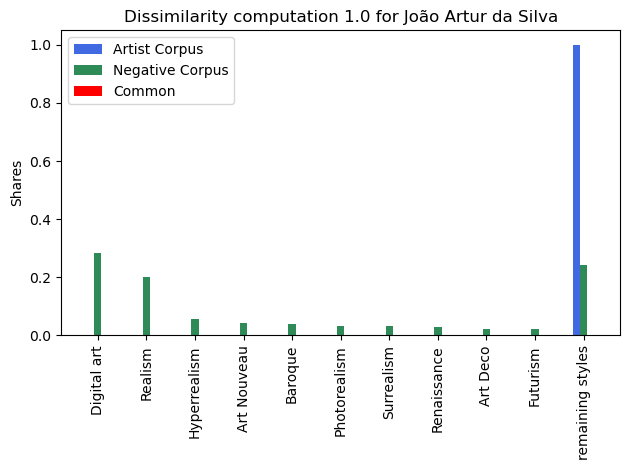

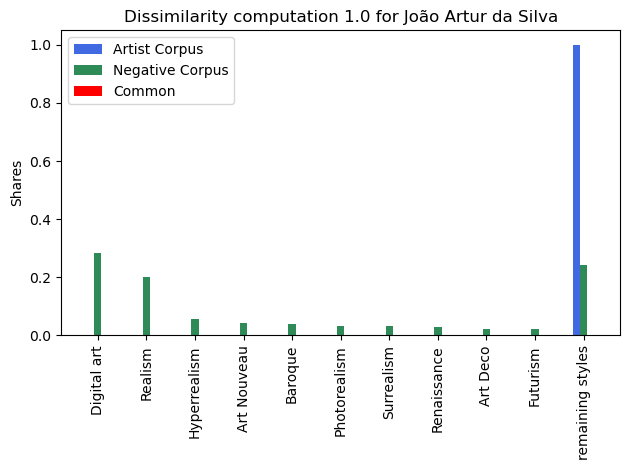

KeyError: 'Greg Rutkowski'

In [5]:
import pandas as pd
import my_utils
import time
import copy
import matplotlib.pyplot as plt


artists = artist_mentions.artist.values

total_all, counts_all = extract_style_counts(exact_matches)

dissimilarities = {}
ineligible_artists=[]

lowest_dissimilarity = 1
highest_dissimilarity = 0

share_df = pd.DataFrame(columns=list(counts_all.keys()))
for index, artist in enumerate(artists):
    
    artist_df = my_utils.exact_match_dataframe(exact_matches, artist)
    
    if artist_df.shape[0] == 0:
        ineligible_artists.append(artist)
        #print(f'{artist} was not mentioned at all')
        continue
    
    assert artist_df.shape[0]>0, f'no match found for {artist}'
    total_artist, counts_artist = extract_style_counts(artist_df)
    
    if total_artist == 0:
        ineligible_artists.append(artist)
        #print(f'{artist} had no mention of any styles')
        continue
    
    total_negative = total_all - total_artist
    counts_negative = copy.deepcopy(counts_all) # counts_negative are the style mentions in (all prompts - artist_df)
    for key, value in counts_negative.items():
        assert value > 0, f'value must be bigger than 0 since we go over all prompts, word {key}'
        assert counts_negative[key] >= counts_artist[key], f'counts of {key} in entire should be higher or equal to specific, {counts_negative[key]} {counts_artist[key]}'
        assert key in counts_artist.keys()
        assert len(counts_artist.keys()) <= len(counts_negative.keys())
        counts_negative[key] = counts_negative[key] - counts_artist[key]
        
    
    
    share_artist = copy.deepcopy(counts_artist) # share the counts make up of all style mentions
    for key, value in share_artist.items():
        share_artist[key]  = value / total_artist
        
    share_negative = copy.deepcopy(counts_negative) # share the counts make up of all style mentions
    for key, value in share_negative.items():
        share_negative[key]  = value / total_negative
                
    s = pd.Series(share_artist, index=share_df.columns, name=artist)
  
    transpose = s.to_frame().T
    if index == 0:
        print(transpose)
    share_df =  pd.concat([share_df, transpose])
    
    dissimilarities[artist] = bc_dissimilarity(share_artist, share_negative)
    
    #if index < 5:
    #    savename=f'../images/{artist}_style_proportions.png'
    #    visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_negative, artist, savename, 10)
        
    if dissimilarities[artist] < lowest_dissimilarity:
        lowest_dissimilarity = dissimilarities[artist]
        savename=f'../images/artist_lowest_dissimilarity.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_negative, artist, savename, 10)
        
        
    if dissimilarities[artist] > highest_dissimilarity:
        highest_dissimilarity = dissimilarities[artist]
        savename=f'../images/artist_highest_dissimilarity.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_negative, artist, savename, 10)
        
    if artist == "Greg Rutkowski":
        savename=f'../images/style_proportions_example.png'
        visualize_style_proportions(share_artist, share_negative, artist, savename, 10)
        savename=f'../images/dissimilarity_calculation_example.png'
        visualize_dissimilarity_computation(dissimilarities[artist], share_artist, share_negative, artist, savename, 10)
        
    
    
share_all = copy.deepcopy(counts_all) # share the counts make up of all style mentions
for key, value in share_all.items():
    share_all[key]  = value / total_all

share_df["dissimilarity"] = dissimilarities    
    
share_df = pd.concat([share_df, pd.Series(share_all, index=share_df.columns, name="overall_dataset").to_frame().T])

print(f'dissimilarity of greg: {dissimilarities["Greg Rutkowski"]}')
print(share_df.head())

print(f'a total of {len(ineligible_artists)} artists were not eligible for the artist characterization by style.')
print(f'a total of {share_df.shape[0]} artists were eligible for the artist characterization by style.')

share_df.to_parquet("../results/artists_style_mention_proportions.parquet")
share_df.to_csv("../results/artists_style_mention_proportions.csv", escapechar="\\")



In [ ]:
print(f'a total of {share_df.shape[0]} artists were eligible for the artist characterization by style.')

In [ ]:
print(f'a total of {len(ineligible_artists)} artists were not elibilbe for the comparison since they were either not mentioned in any prompts or their associated prompts had no style mentions')

ineligible_filename = "../results/ineligible_artists.txt"
with open(ineligible_filename, "w") as file:
    for ia in ineligible_artists:
        file.write(f'{ia}\n')
print(f'ineligible artists saved to {ineligible_filename}')

Index(['Digital art', 'Realism', 'Art Nouveau', 'Romanticism', 'Hyperrealism',
       'Surrealism', 'Baroque', 'Futurism', 'Magic realism', 'Graffiti',
       ...
       'Neo-Dada', 'Verdadism', 'Neo-romanticism', 'Cubo-Futurism',
       'Neo-primitivism', 'Heidelberg School', 'Neo-expressionism', 'Mail art',
       'Art Informel', 'dissimilarity'],
      dtype='object', length=186)


/tmp/ipykernel_1152363/794201136.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels( x_data , rotation=90)


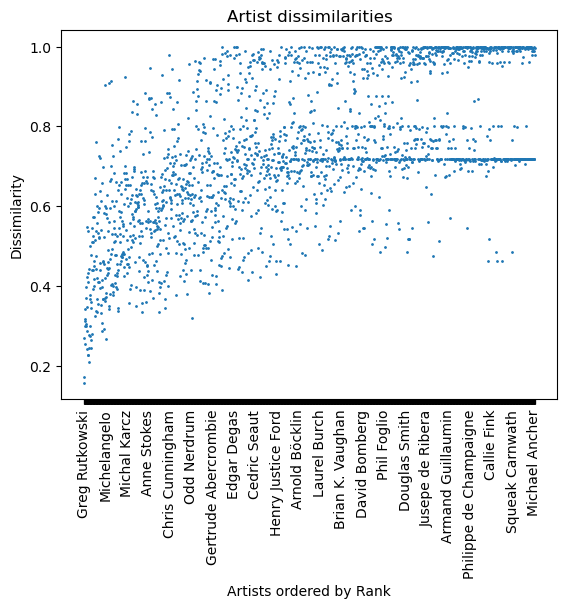

In [4]:
import matplotlib.pyplot as plt
import pandas as pd

share_df = pd.read_parquet("../results/artists_style_mention_proportions.parquet", engine='pyarrow')

print(share_df.columns)

x_data = share_df.index
y_data = [x[1]["dissimilarity"] for x in share_df.iterrows()]


fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(x_data, y_data, s=1)

ax.set_xlabel('Artists ordered by Rank')
ax.set_xticklabels( x_data , rotation=90)
ax.set_ylabel('Dissimilarity')
ax.set_title('Artist dissimilarities')

every_nth = 100
for n, label in enumerate(ax.xaxis.get_ticklabels()):
    if n % every_nth != 0:
        label.set_visible(False)

plt.savefig("../images/ranked_artist_dissimilarity.png", bbox_inches="tight")

plt.show()

In [ ]:
print(f'dissimilarity described')
print(share_df.dissimilarity.describe())

# Spearman Correlation of Artist Rank and dissimilarity

In [ ]:
import pandas as pd
from scipy.stats import spearmanr
import numpy as np

def get_dissimilarity(artist):
    if artist in share_df.index:
        return share_df.loc[[artist]].dissimilarity.item()
    else: 
        return -1

share_df = pd.read_parquet("../results/artists_style_mention_proportions.parquet", engine='pyarrow')

artist_mentions = pd.read_parquet('../results/artist_mentions.parquet', engine='pyarrow')
artist_mentions.sort_values(["mentions"], inplace=True, ascending=False)


artist_mentions['dissimilarity'] = artist_mentions.artist.apply(lambda x: get_dissimilarity(x))

print(share_df.head())
print(artist_mentions.head())

print(artist_mentions[["mentions", "dissimilarity"]].head())

result = spearmanr(artist_mentions[["mentions", "dissimilarity"]])
print(result)
                                                                                      
print(f'pvalue: {result.pvalue}')